# Machine Learning from Disaster

### Step 1: Import Libraries

In [1]:
import zipfile
import os
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Step 2: Load and Read Data

In [2]:
# Unzip and load dataset
zip_file_path = 'Titanic Dataset.zip'
extracted_folder = 'Titanic_data'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

# Load the Titanic CSV into a DataFrame
csv_file_name = os.path.join(extracted_folder, 'Titanic.csv')
df = pd.read_csv(csv_file_name)

# Exploratory Data Analysis (EDA)
print("Initial Dataset Overview:")
print(df.head())
print(df.describe())
print(df.info())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

Initial Dataset Overview:
   PassengerId  Pclass             Name     Sex  Age  SibSp  Parch  \
0            1       3     Allison Hill    male   17      4      2   
1            2       1      Noah Rhodes    male   60      2      2   
2            3       3  Angie Henderson    male   64      0      0   
3            4       3    Daniel Wagner    male   35      4      0   
4            5       1  Cristian Santos  female   70      0      3   

                                 Ticket    Fare Embarked  Survived  
0  43d75413-a939-4bd1-a516-b0d47d3572cc  144.08        Q         1  
1  6334fa2a-8b4b-47e7-a451-5ae01754bf08  249.04        S         0  
2  61a66444-e2af-4629-9efb-336e2f546033   50.31        Q         1  
3  0b6c03c8-721e-4419-afc3-e6495e911b91  235.20        C         1  
4  436e3c49-770e-49db-b092-d40143675d58  160.17        C         1  
       PassengerId       Pclass          Age        SibSp        Parch  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.0

### Step 3: Clean Data

In [3]:
# Data Cleaning
# Fill missing 'Age' with median
median_age = df['Age'].median()
df['Age'] = df['Age'].fillna(median_age)

# Fill missing 'Fare' with median
df['Fare'] = df['Fare'].fillna(df['Fare'].median())

# Fill missing 'Embarked' with mode
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# Convert 'Sex' to numeric
sex_mapping = {'male': 0, 'female': 1}
df['Sex'] = df['Sex'].map(sex_mapping)

# One-hot encode 'Embarked'
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)

### Step 4: Feature Engineering

In [4]:
# Create 'FamilySize' feature
family_size = df['SibSp'] + df['Parch']
df['FamilySize'] = family_size

# Binning 'Age' into groups
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 40, 60, 100], labels=['Child', 'Teen', 'Adult', 'Middle Aged', 'Senior'])
df = pd.get_dummies(df, columns=['AgeGroup'], drop_first=True)

# Drop unnecessary columns
df.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1, inplace=True, errors='ignore')

### Step 5: Visualization

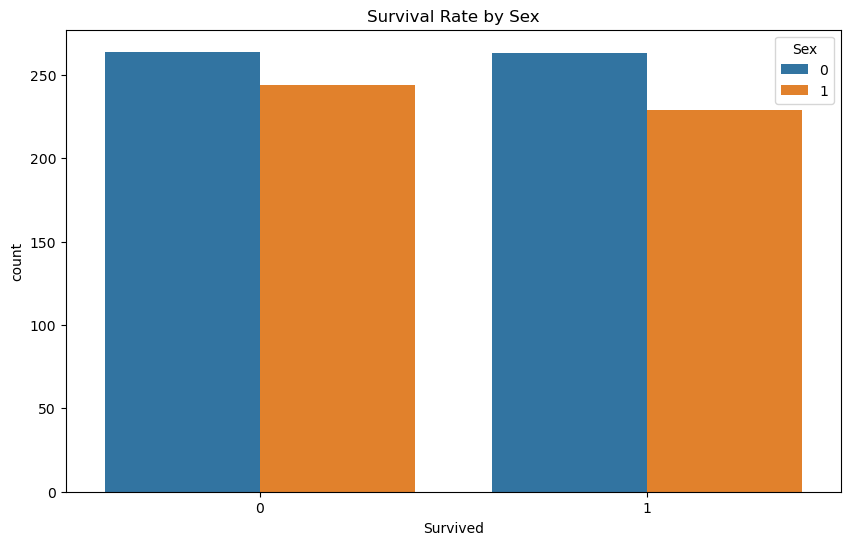

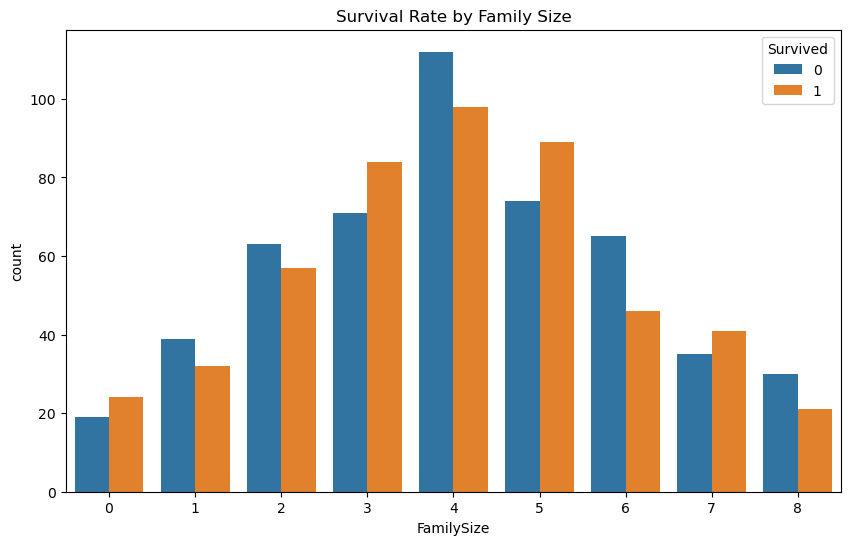

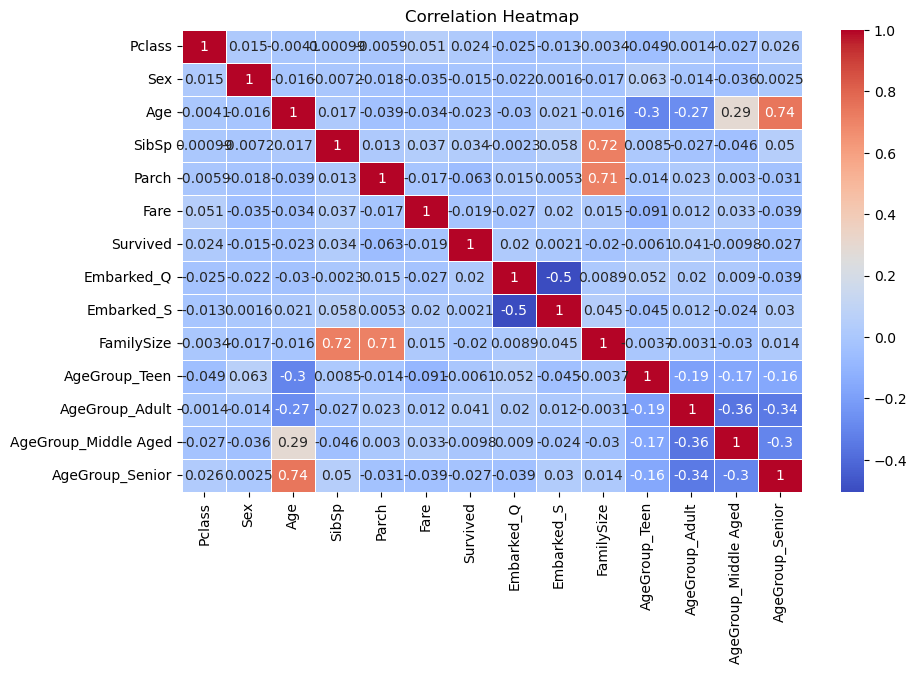

In [5]:
# Visualizations
plt.figure(figsize=(10, 6))
sns.countplot(x='Survived', hue='Sex', data=df)
plt.title('Survival Rate by Sex')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='FamilySize', hue='Survived', data=df)
plt.title('Survival Rate by Family Size')
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 6))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### Step 6: Model Training and Evaluation

In [6]:
# Define features (X) and target (y)
X = df.drop('Survived', axis=1)
y = df['Survived']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Address class imbalance with RandomForestClassifier and GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, None], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

In [8]:
# Best model and evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba)}")

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.545
Confusion Matrix:
[[71 31]
 [60 38]]
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.70      0.61       102
           1       0.55      0.39      0.46        98

    accuracy                           0.55       200
   macro avg       0.55      0.54      0.53       200
weighted avg       0.55      0.55      0.53       200

ROC-AUC Score: 0.5176070428171269


### Step 7: Feature Importance

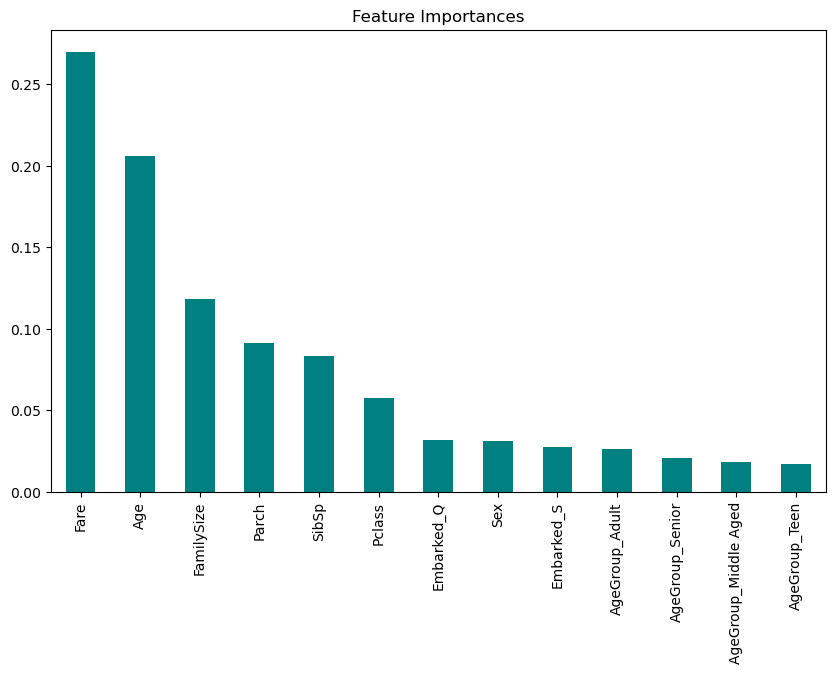

In [9]:
# Plot Feature Importance
plt.figure(figsize=(10, 6))
feature_importances = pd.Series(best_model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', color='teal')
plt.title('Feature Importances')
plt.show()